# Optimizers et schedulers

In [1]:
import matplotlib.pyplot as plt
import plotnine as pn
import torch

from adl import optimizers

pn.theme_set(
    pn.theme_minimal()
    + pn.theme(
        plot_background=pn.element_rect(fill="white"),
        plot_title=pn.element_text(size=11),
    )
)

# Optimizers

Les optimizers et les schedulers sont des techniques et des méthodes permettant d'améliorer le
processus d'apprentissage et de trouver de meilleures valeurs optimales. L'objectif de ce
cahier est de présenter quelques idées sur le fonctionnement de ces méthodes.

## Optimiseurs

Dans les cahiers précédents, nous avons ajusté manuellement les paramètres de nos modèles à partir de nos
valeurs de gradient, à l'aide d'un code tel que celui-ci :

``` python
w = w - step_size * w.grad
b = b - step_size * b.grad
```

Autrement dit, à chaque étape d'apprentissage, nos paramètres (ici $w$ et $b$) étaient
ajustés en ajoutant à leur valeur la valeur du gradient de perte
multipliée par une *taille de pas*, ou *taux d'apprentissage*. 

Ce taux d'apprentissage mesure la distance que nous voulons parcourir dans la direction du gradient à chaque
étape, ce qui peut être considéré de manière approximative comme la vitesse à laquelle nous voulons apprendre à partir des
valeurs de gradient.

Cette méthode simple permet de trouver les valeurs optimales pour les cas les plus simples,
 mais elle peut être considérablement améliorée à l'aide de différentes techniques. 
 
Une méthode permettant de mettre à jour les paramètres du modèle à partir de leurs valeurs de gradient est
appelée *optimiseur*.

Pour illustrer cela, nous utiliserons une fonction de perte plus complexe à deux
paramètres avec plusieurs optimums différents. Elle est représentée ci-dessous sous forme de
graphique de contours : les axes horizontaux et verticaux indiquent les valeurs de nos
deux paramètres, et les contours colorés représentent la valeur de perte à
différents points. Lorsque le contour est rouge, la perte est élevée, lorsqu'il est
bleu foncé, elle est faible. Notre objectif ici est donc d'atteindre le minimum visible
qui se situe autour de (-3, -2).


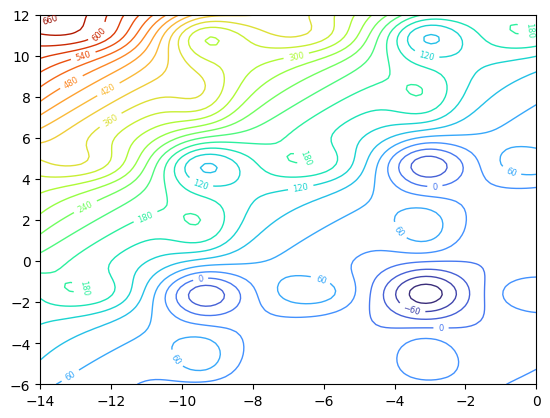

In [2]:
plot_sin_loss_args = {
    "loss_fn": optimizers.sin_loss_fn,
    "w1min": -14,
    "w1max": 0,
    "w2min": -6,
    "w2max": 12,
    "nsteps": 100,
}
optimizers.plot_loss(**plot_sin_loss_args)

Le graphique ci-dessous représente une descente de gradient à partir de (-6,5, 4,5)
et en utilisant une taille de pas, ou taux d'apprentissage, de 0,01. Ainsi, à chaque pas, nous
calculons le gradient de perte au point actuel et nous « nous déplaçons » dans cette
direction en fonction du taux d'apprentissage. Nous pouvons voir que dans ce cas,
nous atteignons la valeur minimale en environ 30 pas.

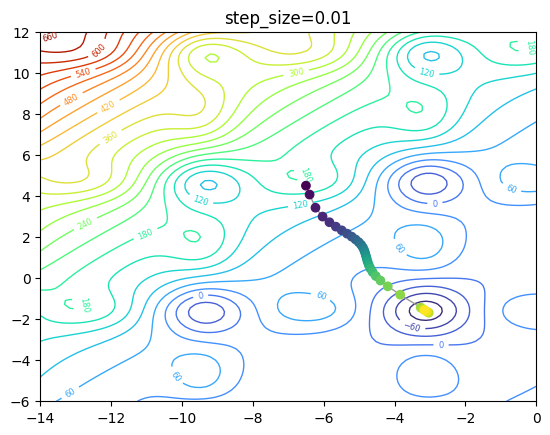

In [3]:
plot_sin_train_args1 = plot_sin_loss_args | {
    "w1_init": -6.5,
    "w2_init": 4.5,
}
optimizers.plot_train(**plot_sin_train_args1, epochs=30, step_size=0.01)

### Stochastic gradient descent

Cette méthode est appelée *descente stochastique du gradient* et, au lieu de
la calculer nous-mêmes, nous pouvons appeler une méthode d'optimisation pytorch prédéfinie
appelée `torch.optim.SGD` qui, par défaut, fait exactement la même chose.

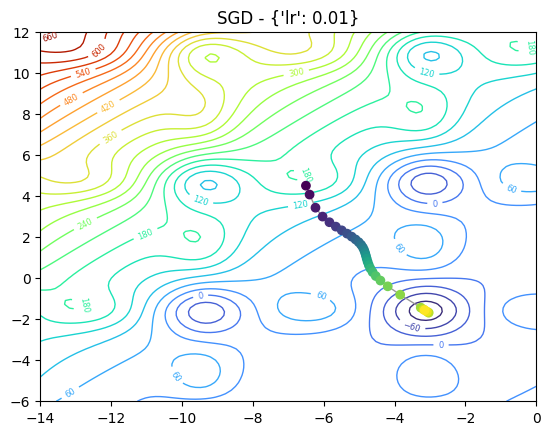

In [4]:
plot_sin_train_args1 = plot_sin_loss_args | {
    "w1_init": -6.5,
    "w2_init": 4.5,
}
optimizers.plot_train(
    **plot_sin_train_args1,
    epochs=30,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.01},
)

Que se passerait-il si nous changions le point de départ ? Dans le graphique ci-dessous, nous
partons de (-12, 10) et nous pouvons voir que la descente de gradient s'arrête à
un autre endroit, qui est un minimum local mais avec une valeur plus élevée que le
meilleur visible.

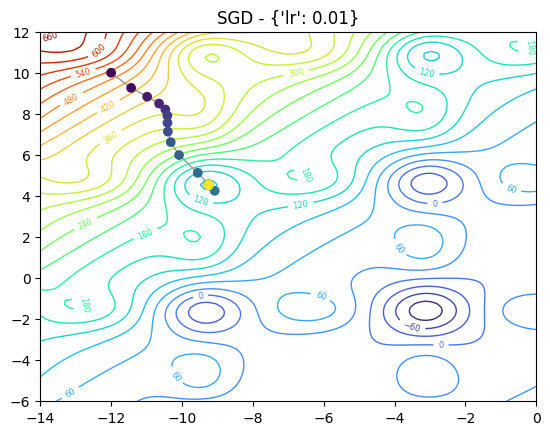

In [5]:
plot_sin_train_args2 = plot_sin_loss_args | {
    "w1_init": -12.0,
    "w2_init": 10.0,
}
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=30,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.01},
)

Cela illustre le fait que le processus d'apprentissage n'est pas
déterministe : si nous commençons à un point aléatoire, *c'est-à-dire* avec les paramètres de notre modèle
initialisés avec des valeurs aléatoires, la descente sera différente
et pourrait ne pas aboutir à la même valeur optimale.

Cela illustre également un inconvénient de la méthode de descente de gradient : si nous
nous arrêtons au premier endroit où les valeurs du gradient sont nulles,
nous savons que nous sommes à un point minimum, mais il pourrait s'agir d'un minimum local
plutôt que d'un minimum global. En fait, il n'y a aucun moyen de savoir si le minimum
est local ou global.

Plusieurs techniques ont été développées pour améliorer ce comportement. L'une d'entre elles
consiste à ajouter une « impulsion » à notre processus d'apprentissage : cela peut être considéré comme un
moyen d'ajouter une « inertie » à notre descente, ce qui peut permettre d'échapper à un
minimum local dans certains cas. Dans l'exemple suivant, nous avons le même
point de départ et le même taux d'apprentissage que précédemment, mais l'ajout d'une impulsion
permet d'aller au-delà du premier minimum local et de se diriger vers la valeur la plus basse.

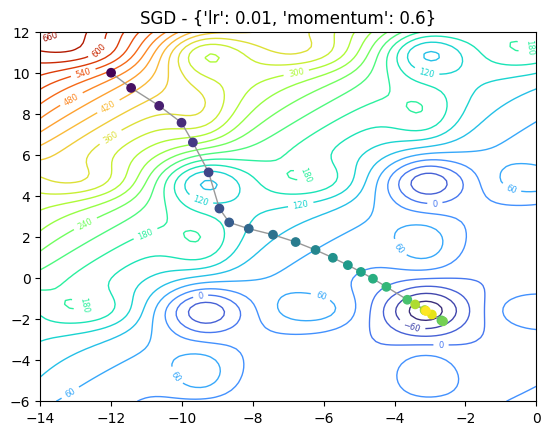

In [6]:
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=25,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.01, "momentum": 0.6},
)

Bien sûr, l'importance de l'élan ajouté est importante : trop faible, il ne
permettra pas d'échapper à un minimum local, et trop important, il peut accélérer la descente
et empêcher d'atteindre l'optimum souhaité, comme dans l'
exemple suivant.

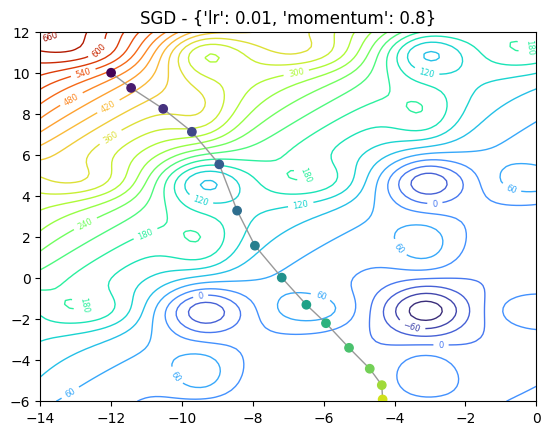

In [7]:
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=15,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.01, "momentum": 0.8},
)

### Autres optimiseurs

Une autre limite de la descente stochastique du gradient est qu'elle utilise un
taux d'apprentissage fixe, qui est le même pour chaque paramètre à chaque
étape d'apprentissage. D'autres optimiseurs utilisent des taux d'apprentissage adaptatifs, c'est-à-dire qu'ils
ajustent les valeurs en fonction des valeurs de gradient précédentes : ils réduisent
le taux d'apprentissage pour les paramètres ayant un historique de valeurs de gradient élevées,
et l'augmentent pour les paramètres ayant des valeurs de gradient faibles.

Nous allons illustrer cela avec une autre fonction de perte plus simple, toujours pour
deux paramètres :

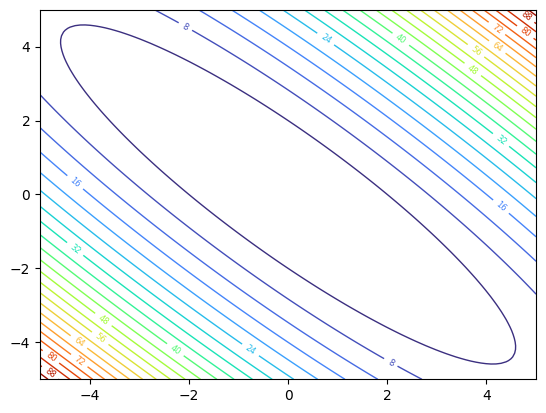

In [8]:
plot_reg_loss_args = {
    "loss_fn": optimizers.reg_loss_fn,
    "w1min": -5,
    "w1max": 5,
    "w2min": -5,
    "w2max": 5,
    "nsteps": 100,
}
optimizers.plot_loss(**plot_reg_loss_args)

Dans le graphique suivant, nous comparons l'optimiseur `torch.optim.SGD`, avec un
taux d'apprentissage fixe, et un autre optimiseur appelé `torch.optim.RMSprop`,
avec des taux d'apprentissage adaptatifs. Nous pouvons voir que, pour le même taux d'apprentissage global,
RMSprop minimise les oscillations en réduisant les
taux d'apprentissage lorsque les gradients ont des valeurs élevées pendant plusieurs étapes d'entraînement.

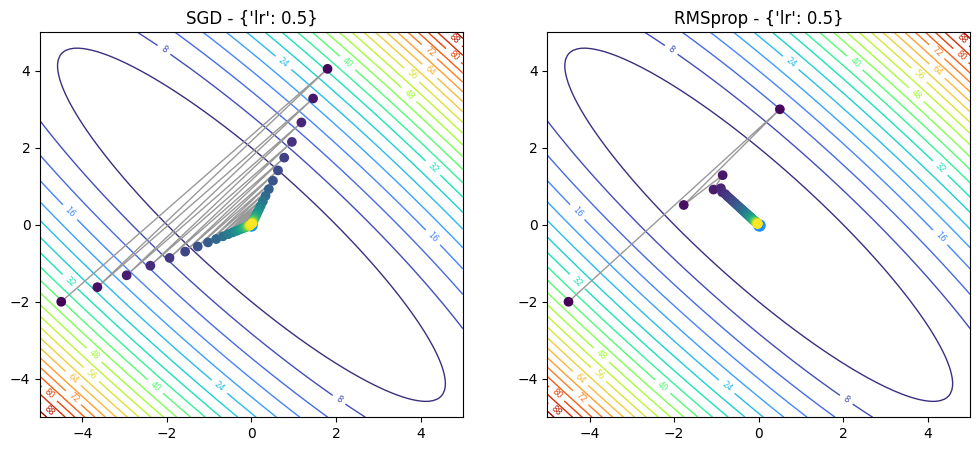

In [9]:
plot_reg_train_args = plot_reg_loss_args | {
    "w1_init": -4.5,
    "w2_init": -2.0,
    "optimum": (0.0, 0.0),
}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
optimizers.plot_train(
    **plot_reg_train_args,
    epochs=50,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.5},
    ax=ax1,
)
optimizers.plot_train(
    **plot_reg_train_args,
    epochs=50,
    optimizer=torch.optim.RMSprop,  # type: ignore
    optimizer_params={"lr": 0.5},
    ax=ax2,
)
plt.show()

Un autre optimiseur avec taux d'apprentissage adaptatif est `torch.optim.AdamW`,
qui implémente à la fois le taux d'apprentissage adaptatif et l'élan. Il utilise également
par défaut la notion de *décroissance des poids*, qui est une technique de régularisation
encourageant des valeurs plus petites pour les paramètres.

(Ici vous vous demanderez peut être pourquoi travailler sur les paramètres en encourageant des valeurs plus petites pour les paramètres alors que l'on veut trouver le minimum globale en parcourant le maximum de solution possible ce qui est contraire la *décroissance des poids*. C'est en fait dans l'optique de ne pas overfitter les données dans des réseaux de neurone plus complexe. Par exemple, un réseaux qui identifie des image, le minimum global pourrait être un modèle qui a mémorisé chaque pixel de chaque image d'entraînement mais qui échoue sur de nouvelles image. Avec cette technique on se dirige donc vers des minimum moins étroit.)

Lorsqu'il est utilisé dans le même exemple avec le même taux d'apprentissage initial, nous
pouvons voir que cela conduit à une descente plus douce, même si elle est un peu
plus lente au début.

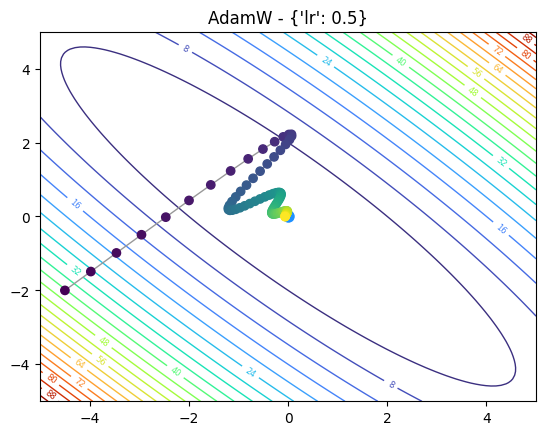

In [10]:
optimizers.plot_train(
    **plot_reg_train_args,
    epochs=80,
    optimizer=torch.optim.AdamW,  # type: ignore
    optimizer_params={"lr": 0.5},
)

Si nous augmentons le taux d'apprentissage, nous pouvons voir que la descente SGD commence à diverger et n'atteint pas la valeur optimale, tandis que RMSprop continue
de converger et qu'AdamW présente une descente presque identique, bien qu'un peu plus rapide.

Cela rend RMSprop et AdamW un peu moins dépendants de la valeur initiale
du taux d'apprentissage que SGD.

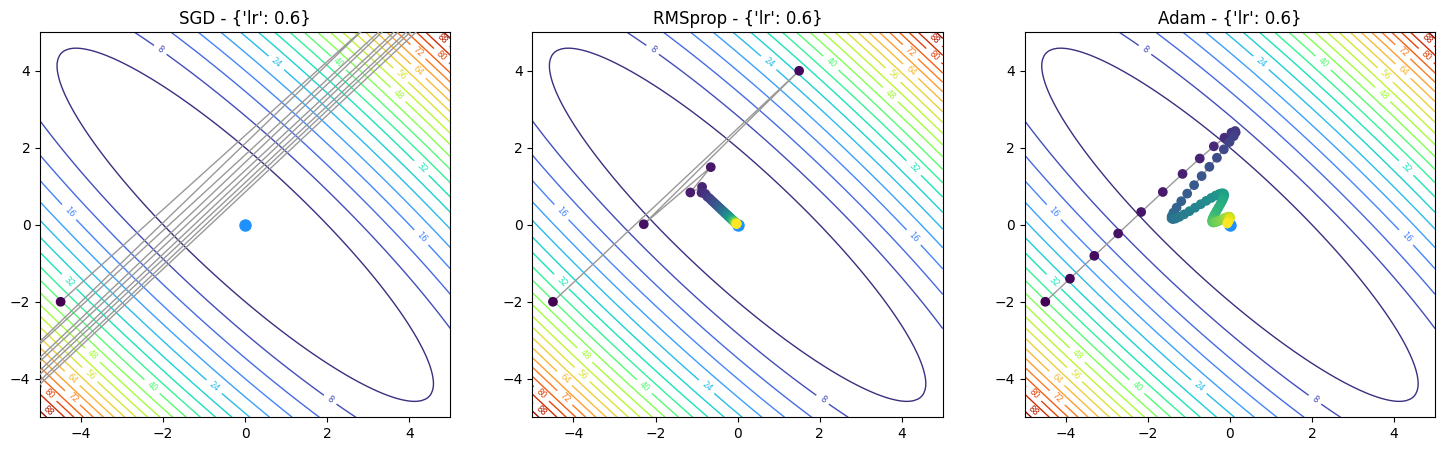

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
optimizers.plot_train(
    **plot_reg_train_args,
    epochs=10,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.6},
    ax=ax1,
)
optimizers.plot_train(
    **plot_reg_train_args,
    epochs=50,
    optimizer=torch.optim.RMSprop,  # type: ignore
    optimizer_params={"lr": 0.6},
    ax=ax2,
)
optimizers.plot_train(
    **plot_reg_train_args,
    epochs=70,
    optimizer=torch.optim.Adam,  # type: ignore
    optimizer_params={"lr": 0.6},
    ax=ax3,
)
plt.show()

Enfin, nous pouvons comparer le processus d'apprentissage de SGD, RMSprop et AdamW
sur notre exemple de perte complexe.

Tout d'abord, pour SGD, le résultat dépend fortement du taux d'apprentissage initial.
 De plus, le taux d'apprentissage fixe peut entraîner de fortes
oscillations autour de la valeur optimale.

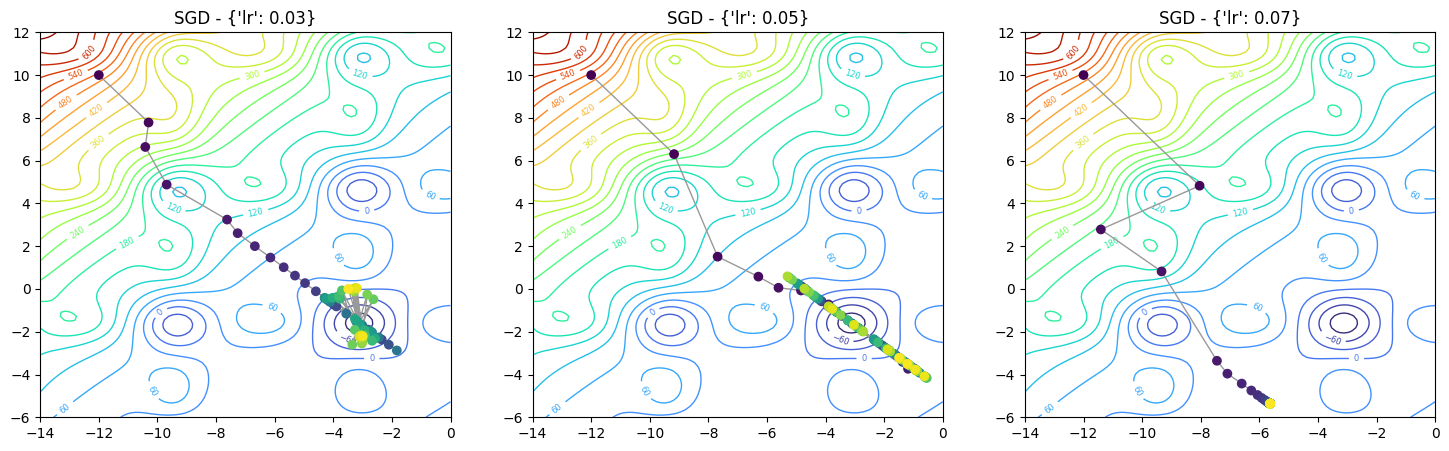

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=60,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.03},
    ax=ax1,
)
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=100,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.05},
    ax=ax2,
)
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=60,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.07},
    ax=ax3,
)
plt.show()

RMSprop dépend également beaucoup du taux d'apprentissage initial. Si la
valeur est trop faible, nous pouvons rester bloqués dans un minimum local, et si elle est trop
élevée, nous pouvons « échapper » au minimum global visible et le dépasser.

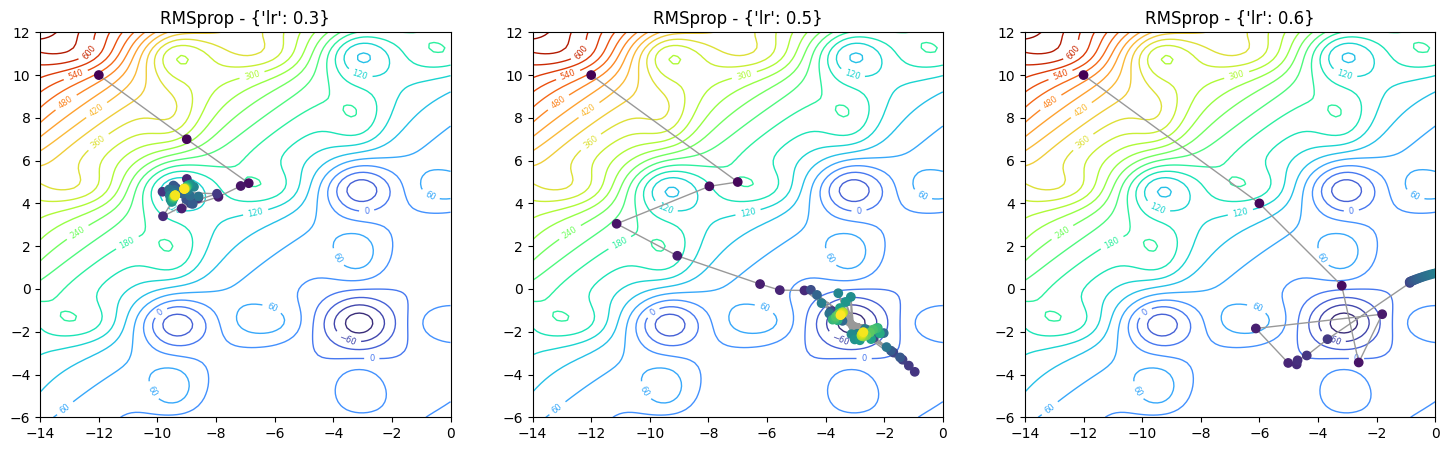

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=60,
    optimizer=torch.optim.RMSprop,  # type: ignore
    optimizer_params={"lr": 0.3},
    ax=ax1,
)
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=60,
    optimizer=torch.optim.RMSprop,  # type: ignore
    optimizer_params={"lr": 0.5},
    ax=ax2,
)
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=60,
    optimizer=torch.optim.RMSprop,  # type: ignore
    optimizer_params={"lr": 0.6},
    ax=ax3,
)
plt.show()

Enfin, `AdamW` est moins sensible au taux d'apprentissage initial. Même
avec des valeurs extrêmes plus basses et plus élevées que dans notre exemple RMSprop, il
parvient à atteindre l'optimum visible avec une descente plus régulière.

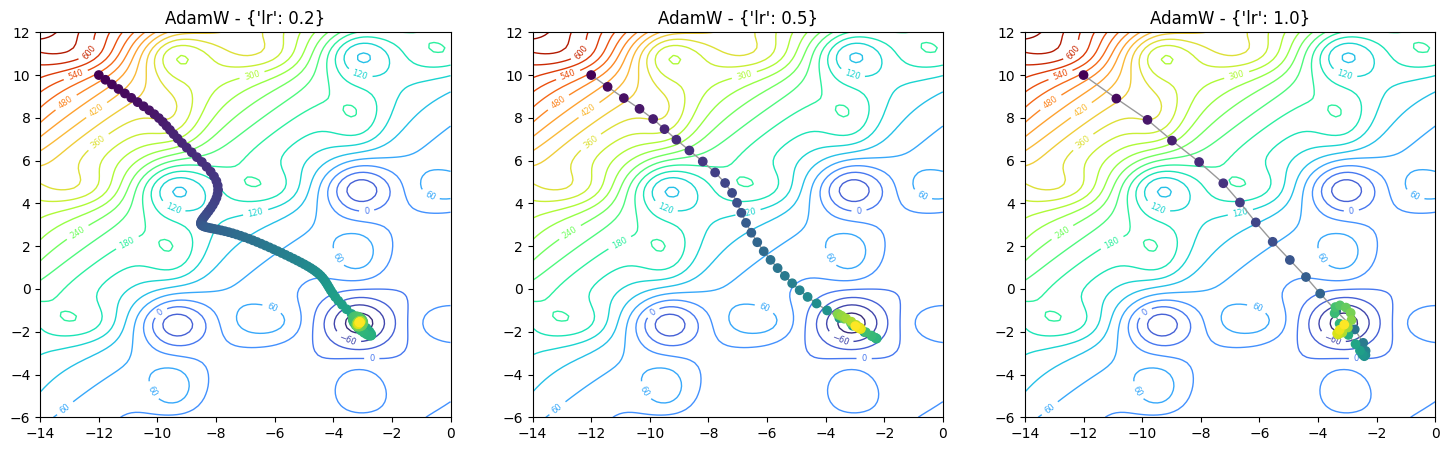

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=150,
    optimizer=torch.optim.AdamW,  # type: ignore
    optimizer_params={"lr": 0.2},
    ax=ax1,
)
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=50,
    optimizer=torch.optim.AdamW,  # type: ignore
    optimizer_params={"lr": 0.5},
    ax=ax2,
)
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=35,
    optimizer=torch.optim.AdamW,  # type: ignore
    optimizer_params={"lr": 1.0},
    ax=ax3,
)
plt.show()

# Optimiseurs dans PyTorch

Dans les notebooks précédents, nous n'avons pas utilisé les optimiseurs PyTorch, mais avons ajusté
nos paramètres manuellement.

Pour utiliser un optimiseur défini par PyTorch, nous devons d'abord créer une instance d'optimiseur
en invoquant une méthode d'optimiseur à partir de `torch.optim`, comme
`torch.optim.SGD` ou `torch.optim.AdamW`. Nous passons les paramètres de notre modèle
comme premier argument, suivi d'autres arguments de l'optimiseur tels que le
taux d'apprentissage.

Par exemple, pour créer un optimiseur `SGD` sur deux paramètres du modèle `w`
et `b` avec un taux d'apprentissage de 0,001 :

``` python
optimizer = torch.optim.SGD([w, b], lr=0.001)
```

Ensuite, nous obtenons deux méthodes que nous pouvons utiliser dans notre boucle d'entraînement :

- `optimizer.step()` ajustera les valeurs des paramètres en fonction de
  leurs gradients
- `optimizer.zero_grad()` réinitialisera les valeurs des gradients.

**Exercice 1**

Modifiez le code d'entraînement suivant, vu dans le notebook précédent, en
utilisant un optimiseur `torch.optimizer.SGD` avec un taux d'apprentissage de 0,001.
Vérifiez que les deux codes donnent les mêmes résultats.

In [21]:
# x and y data
x = torch.tensor([-1.5, 0.2, 3.4, 4.1, 7.8, 13.4, 18.0, 21.5, 32.0, 33.5])
y = torch.tensor([100.5, 110.2, 133.5, 141.2, 172.8, 225.1, 251.0, 278.9, 366.7, 369.9])

# Parameters
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)


def forward(x):
    return w * x + b


loss_fn = torch.nn.MSELoss()

step_size = 0.001
epochs = 1000
for epoch in range(epochs):
    y_pred = forward(x)
    loss = loss_fn(y_pred, y)
    loss.backward()

    # weight and bias adjustment
    w.data = w.data - step_size * w.grad  # type: ignore
    b.data = b.data - step_size * b.grad  # type: ignore

    # reset gradients
    w.grad.zero_()  # type: ignore
    b.grad.zero_()  # type: ignore

    print(f"Epoch: {epoch}, loss: {loss:.2f}, weight: {w:.3f}, bias: {b:.3f}")

Epoch: 0, loss: 55261.49, weight: 7.982, bias: 0.430
Epoch: 1, loss: 11868.83, weight: 10.838, bias: 0.648
Epoch: 2, loss: 6292.87, weight: 11.859, bias: 0.789
Epoch: 3, loss: 5568.87, weight: 12.221, bias: 0.904
Epoch: 4, loss: 5467.40, weight: 12.349, bias: 1.008
Epoch: 5, loss: 5445.81, weight: 12.392, bias: 1.109
Epoch: 6, loss: 5434.49, weight: 12.405, bias: 1.209
Epoch: 7, loss: 5424.50, weight: 12.407, bias: 1.308
Epoch: 8, loss: 5414.70, weight: 12.405, bias: 1.407
Epoch: 9, loss: 5404.94, weight: 12.401, bias: 1.505
Epoch: 10, loss: 5395.19, weight: 12.398, bias: 1.604
Epoch: 11, loss: 5385.47, weight: 12.394, bias: 1.702
Epoch: 12, loss: 5375.76, weight: 12.390, bias: 1.801
Epoch: 13, loss: 5366.07, weight: 12.385, bias: 1.899
Epoch: 14, loss: 5356.40, weight: 12.381, bias: 1.997
Epoch: 15, loss: 5346.75, weight: 12.377, bias: 2.095
Epoch: 16, loss: 5337.11, weight: 12.373, bias: 2.193
Epoch: 17, loss: 5327.49, weight: 12.369, bias: 2.291
Epoch: 18, loss: 5317.89, weight: 12.

In [22]:
# x and y data
x = torch.tensor([-1.5, 0.2, 3.4, 4.1, 7.8, 13.4, 18.0, 21.5, 32.0, 33.5])
y = torch.tensor([100.5, 110.2, 133.5, 141.2, 172.8, 225.1, 251.0, 278.9, 366.7, 369.9])

# Parameters
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)


def forward(x):
    return w * x + b

optimizer = torch.optim.SGD([w,b], lr=0.001)
loss_fn = torch.nn.MSELoss()

step_size = 0.001
epochs = 1000

for epoch in range(epochs):
    y_pred = forward(x)
    loss = loss_fn(y_pred, y)
    loss.backward()

    # weight and bias adjustment
    optimizer.step()
    #w.data = w.data - step_size * w.grad  # type: ignore
    #b.data = b.data - step_size * b.grad  # type: ignore

    # reset gradients
    optimizer.zero_grad()
    #w.grad.zero_()  # type: ignore
    #b.grad.zero_()  # type: ignore

    print(f"Epoch: {epoch}, loss: {loss:.2f}, weight: {w:.3f}, bias: {b:.3f}")

Epoch: 0, loss: 55261.49, weight: 7.982, bias: 0.430
Epoch: 1, loss: 11868.83, weight: 10.838, bias: 0.648
Epoch: 2, loss: 6292.87, weight: 11.859, bias: 0.789
Epoch: 3, loss: 5568.87, weight: 12.221, bias: 0.904
Epoch: 4, loss: 5467.40, weight: 12.349, bias: 1.008
Epoch: 5, loss: 5445.81, weight: 12.392, bias: 1.109
Epoch: 6, loss: 5434.49, weight: 12.405, bias: 1.209
Epoch: 7, loss: 5424.50, weight: 12.407, bias: 1.308
Epoch: 8, loss: 5414.70, weight: 12.405, bias: 1.407
Epoch: 9, loss: 5404.94, weight: 12.401, bias: 1.505
Epoch: 10, loss: 5395.19, weight: 12.398, bias: 1.604
Epoch: 11, loss: 5385.47, weight: 12.394, bias: 1.702
Epoch: 12, loss: 5375.76, weight: 12.390, bias: 1.801
Epoch: 13, loss: 5366.07, weight: 12.385, bias: 1.899
Epoch: 14, loss: 5356.40, weight: 12.381, bias: 1.997
Epoch: 15, loss: 5346.75, weight: 12.377, bias: 2.095
Epoch: 16, loss: 5337.11, weight: 12.373, bias: 2.193
Epoch: 17, loss: 5327.49, weight: 12.369, bias: 2.291
Epoch: 18, loss: 5317.89, weight: 12.

**Exercice 2**

Modifiez à nouveau le code pour utiliser désormais un optimiseur `AdamW` avec un taux d'apprentissage
de 0,5.

In [24]:
# x and y data
x = torch.tensor([-1.5, 0.2, 3.4, 4.1, 7.8, 13.4, 18.0, 21.5, 32.0, 33.5])
y = torch.tensor([100.5, 110.2, 133.5, 141.2, 172.8, 225.1, 251.0, 278.9, 366.7, 369.9])

# Parameters
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)


def forward(x):
    return w * x + b

optimizer = torch.optim.AdamW([w,b], lr=0.5)
loss_fn = torch.nn.MSELoss()

step_size = 0.001
epochs = 1000

for epoch in range(epochs):
    y_pred = forward(x)
    loss = loss_fn(y_pred, y)
    loss.backward()

    # weight and bias adjustment
    optimizer.step()
    #w.data = w.data - step_size * w.grad  # type: ignore
    #b.data = b.data - step_size * b.grad  # type: ignore

    # reset gradients
    optimizer.zero_grad()
    #w.grad.zero_()  # type: ignore
    #b.grad.zero_()  # type: ignore

    print(f"Epoch: {epoch}, loss: {loss:.2f}, weight: {w:.3f}, bias: {b:.3f}")

Epoch: 0, loss: 55261.49, weight: 0.500, bias: 0.500
Epoch: 1, loss: 51142.60, weight: 0.997, bias: 0.997
Epoch: 2, loss: 47222.03, weight: 1.490, bias: 1.491
Epoch: 3, loss: 43499.89, weight: 1.979, bias: 1.981
Epoch: 4, loss: 39975.88, weight: 2.464, bias: 2.466
Epoch: 5, loss: 36649.18, weight: 2.943, bias: 2.948
Epoch: 6, loss: 33518.54, weight: 3.416, bias: 3.424
Epoch: 7, loss: 30582.12, weight: 3.883, bias: 3.896
Epoch: 8, loss: 27837.58, weight: 4.344, bias: 4.361
Epoch: 9, loss: 25281.97, weight: 4.796, bias: 4.821
Epoch: 10, loss: 22911.79, weight: 5.241, bias: 5.274
Epoch: 11, loss: 20722.92, weight: 5.676, bias: 5.720
Epoch: 12, loss: 18710.65, weight: 6.102, bias: 6.159
Epoch: 13, loss: 16869.71, weight: 6.518, bias: 6.591
Epoch: 14, loss: 15194.21, weight: 6.923, bias: 7.014
Epoch: 15, loss: 13677.72, weight: 7.316, bias: 7.429
Epoch: 16, loss: 12313.27, weight: 7.697, bias: 7.835
Epoch: 17, loss: 11093.43, weight: 8.066, bias: 8.232
Epoch: 18, loss: 10010.32, weight: 8.4

## Schedulers

Les schedulers sont un autre ensemble de méthodes conçues pour améliorer le processus d'apprentissage.
 L'objectif d'un Schedulers est de modifier le taux d'apprentissage pendant le
processus.

Nous commencerons par l'exemple suivant de descente de gradient, avec un optimiseur `SGD`.
 Nous pouvons voir qu'avec un taux d'apprentissage de 0,04, la descente
atteint la zone du minimum visible, mais commence ensuite à osciller
indéfiniment autour du minimum au lieu de l'atteindre réellement.

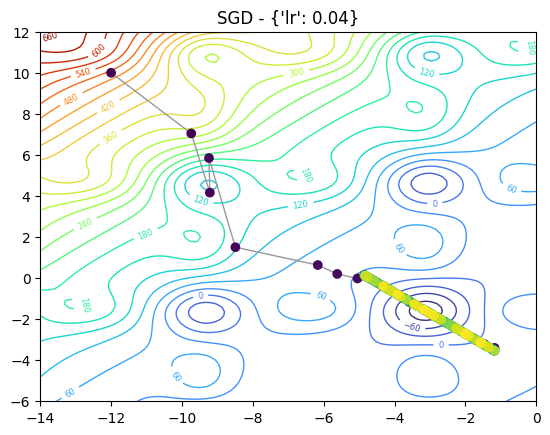

In [25]:
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=250,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.04},
)


Cette oscillation est due à la valeur fixe du taux d'apprentissage dans
`SGD`. Le taux d'apprentissage élevé est utile au début de l'entraînement
car il évite un minimum local, mais il devient préjudiciable à la fin
car il empêche de se stabiliser et d'atteindre la valeur optimale.

Une façon de contourner ce problème consiste à utiliser un *scheduler* qui
diminuera régulièrement le taux d'apprentissage tout au long du processus d'entraînement. 

Dans l'exemple suivant, nous utilisons un planificateur `ExponentialLR` avec un argument `gamma` de 0,95, ce qui signifie qu'à chaque étape d'entraînement, le taux d'apprentissage sera multiplié par 0,95.

Cela permet d'éviter le problème d'oscillation à la fin de la descente.

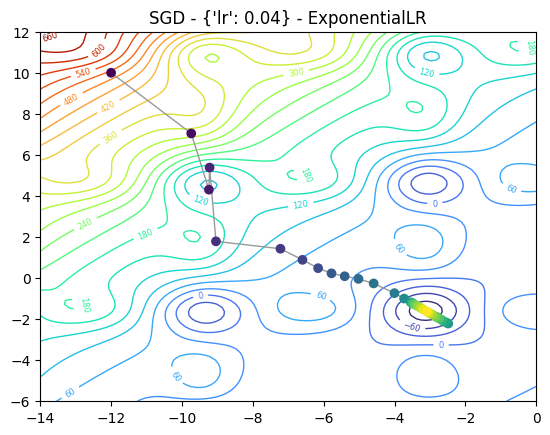

In [26]:
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=30,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.04},
    scheduler=torch.optim.lr_scheduler.ExponentialLR,
    scheduler_params={"gamma": 0.95},
)

Il existe de nombreux planificateurs différents, tels que
`ReduceLROnPlateau`, qui réduit le taux d'apprentissage uniquement si la valeur de perte
n'a pas diminué pendant un certain nombre d'étapes d'entraînement.

Ici, nous l'utilisons avec un `facteur` de 0,8 et une `patience` de 0, ce qui signifie
que le taux d'apprentissage sera multiplié par 0,8 dès que la valeur de perte
ne sera pas inférieure à celle de l'étape précédente.

Nous pouvons voir que cette méthode permet également d'éviter le problème d'oscillation
à la fin de l'entraînement.

/home/tim/miniconda3/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)


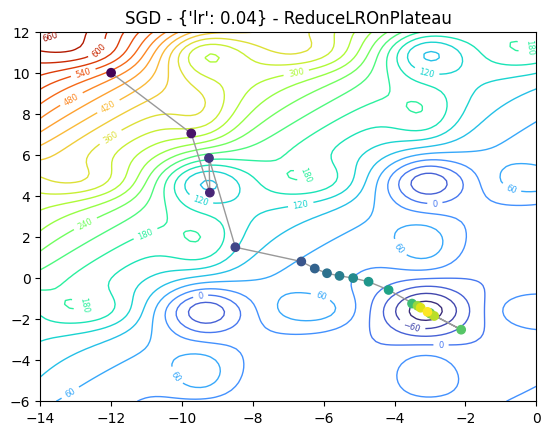

In [27]:
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=20,
    optimizer=torch.optim.SGD,  # type: ignore
    optimizer_params={"lr": 0.04},
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params={"patience": 0, "factor": 0.8},
)

Les planificateurs peuvent être utiles même pour les optimiseurs qui utilisent un taux d'apprentissage adaptatif.
Si nous utilisons RMSprop dans l'exemple précédent, nous pouvons voir que nous
pouvons toujours avoir le problème d'oscillation montré par SGD : à la fin du
processus, le modèle oscille entre deux valeurs autour de l'optimum.

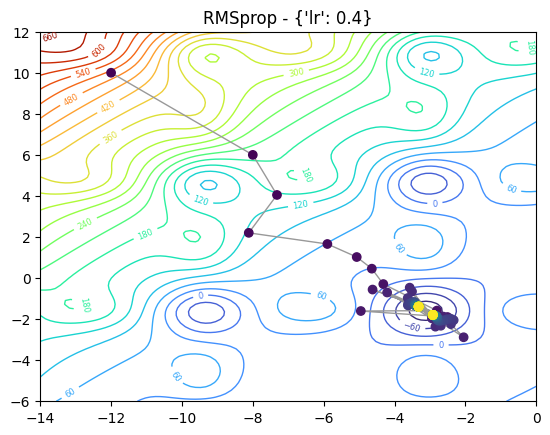

In [28]:
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=150,
    optimizer=torch.optim.RMSprop,  # type: ignore
    optimizer_params={"lr": 0.4},
)

Si nous utilisons un planificateur « ReduceLROnPlateau », le problème d'oscillation disparaît.

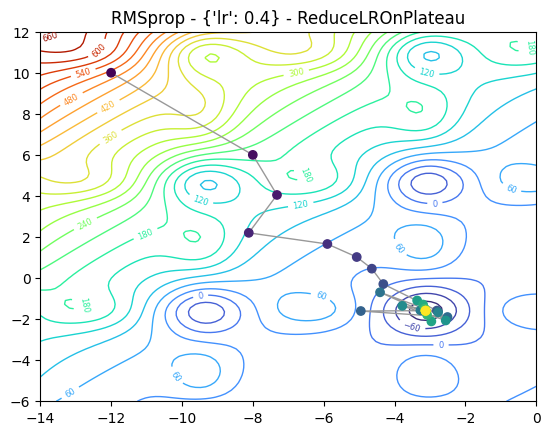

In [29]:
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=30,
    optimizer=torch.optim.RMSprop,  # type: ignore
    optimizer_params={"lr": 0.4},
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params={"patience": 0, "factor": 0.9},
)

Enfin, nous pouvons constater que les optimiseurs plus modernes tels que `AdamW` ne semblent pas
présenter le même problème, car ils adaptent mieux le taux d'apprentissage par
eux-mêmes.

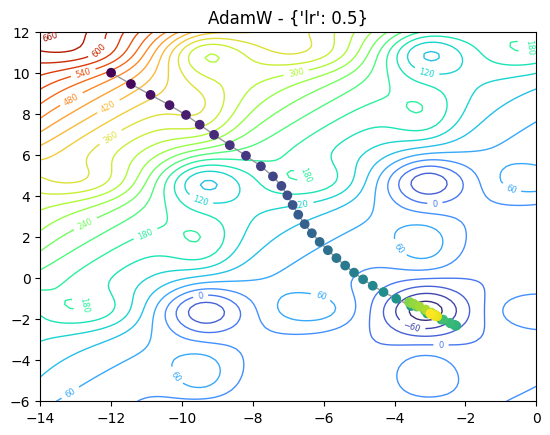

In [30]:
optimizers.plot_train(
    **plot_sin_train_args2,
    epochs=50,
    optimizer=torch.optim.AdamW,  # type: ignore
    optimizer_params={"lr": 0.5},
)


Cependant, d'autres types de schedulers peuvent être utilisés avec ces optimizers,
en particulier avec des modèles plus volumineux, par exemple pour introduire une période de préchauffage
au début de l'entraînement. Dans ce cas, le taux d'apprentissage commence à partir d'une
petite valeur et augmente progressivement jusqu'au taux d'apprentissage initial souhaité
au cours de quelques époques.

### Schedulers dans pytorch

Pour utiliser un schedulers pytorch dans notre processus d'entraînement, nous devons créer une
instance de schedulers en lui passant un objet optimiseur et des arguments supplémentaires.
 Par exemple, pour utiliser un schedulers `ReduceLROnPlateau` :

``` python
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.9)
```

Ensuite, nous pouvons utiliser la méthode `scheduler.step()` à la fin de chaque
époque pour modifier le taux d'apprentissage de notre optimiseur.

**Exercice 3**

Modifiez la réponse de l'exercice 1 ci-dessus pour utiliser un
schedulers `torch.optim.lr_scheduler.ExponentialLR` avec un argument `gamma`
de 0,99.

In [35]:
# x and y data
x = torch.tensor([-1.5, 0.2, 3.4, 4.1, 7.8, 13.4, 18.0, 21.5, 32.0, 33.5])
y = torch.tensor([100.5, 110.2, 133.5, 141.2, 172.8, 225.1, 251.0, 278.9, 366.7, 369.9])

# Parameters
w = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)


def forward(x):
    return w * x + b

optimizer = torch.optim.SGD([w,b], lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
loss_fn = torch.nn.MSELoss()

step_size = 0.001
epochs = 1000

for epoch in range(epochs):
    y_pred = forward(x)
    loss = loss_fn(y_pred, y)
    loss.backward()

    # weight and bias adjustment
    optimizer.step()
    #w.data = w.data - step_size * w.grad  # type: ignore
    #b.data = b.data - step_size * b.grad  # type: ignore

    # reset gradients
    optimizer.zero_grad()
    #w.grad.zero_()  # type: ignore
    #b.grad.zero_()  # type: ignore
    scheduler.step()

    print(f"Epoch: {epoch}, loss: {loss:.2f}, weight: {w:.3f}, bias: {b:.3f}, lr: {scheduler.get_last_lr()[0]:.6f}")

Epoch: 0, loss: 55261.49, weight: 7.982, bias: 0.430, lr: 0.000990
Epoch: 1, loss: 11868.83, weight: 10.810, bias: 0.646, lr: 0.000980
Epoch: 2, loss: 6322.59, weight: 11.828, bias: 0.785, lr: 0.000970
Epoch: 3, loss: 5580.87, weight: 12.199, bias: 0.897, lr: 0.000961
Epoch: 4, loss: 5471.12, weight: 12.335, bias: 0.998, lr: 0.000951
Epoch: 5, loss: 5447.50, weight: 12.385, bias: 1.094, lr: 0.000941
Epoch: 6, loss: 5436.09, weight: 12.401, bias: 1.188, lr: 0.000932
Epoch: 7, loss: 5426.55, weight: 12.406, bias: 1.281, lr: 0.000923
Epoch: 8, loss: 5417.39, weight: 12.405, bias: 1.372, lr: 0.000914
Epoch: 9, loss: 5408.37, weight: 12.403, bias: 1.462, lr: 0.000904
Epoch: 10, loss: 5399.46, weight: 12.399, bias: 1.551, lr: 0.000895
Epoch: 11, loss: 5390.66, weight: 12.396, bias: 1.640, lr: 0.000886
Epoch: 12, loss: 5381.96, weight: 12.393, bias: 1.727, lr: 0.000878
Epoch: 13, loss: 5373.36, weight: 12.389, bias: 1.813, lr: 0.000869
Epoch: 14, loss: 5364.86, weight: 12.385, bias: 1.898, lr

# Résumé : Optimizers et Schedulers

- Un optimizer permet de mettre à jour les paramètres du modèle à partir de leurs valeurs de gradient (même chose que la descente de gradient). On a également vu que le processus d'apprentissage n'est pas déterministe.

    - $SGD$ : optimizer avec lequel on peut ajouter un *momentum* (impulsion) qui nous permet de trouver le minimum global. La valeur du *momentum* est importante ici ! 

    - Une autre limite de la descente de gradient est quelle possède un taux d'apprentissage fixe (pour chaque paramètre et chaque étape (epoch)).

    - $RMSprop$ : optimizer qui permet des taux d'apprentissage adaptatif. On a vu que cela permet de minimiser les oscillation pour le même taux d'apprentissage global (en réduisant les taux d'apprentissage lorsque les gradient ont des valeurs élevées). Il calcule un taux d'apprentissage différent pour chaque poids du modèle (différent d'un scheduler qui modifie le taux pour tout le modèle en même temps.)

    - $AdamW$ : optimizer qui implémente à la fois le taux d'apprentissage adaptatif et l'élan. Il utilise également la notion de *décroissance des poidsµ qui encourage des valeurs plus petites pour les paramètres. (évite le problème d'overfitting, voir paragraphe plus haut.)


- Un scheduler permet de modifier le taux d'apprentissage pendant le processus en effet un taux élevé peut être utile au début du training mais peut donné modèle divergent à la fin.

    - $ExponentialLR$ : A chaque étape d'apprentissage le taux d'apprentissage sera multiplié par un paramètre *gamma*. (Permet d'évite les problème d'oscillation à la fin de la descente.)

    - $ReduceLROnPlateau$ : réduit (*facteur*) le taux d'apprentissage uniquement si la valeur de perte n'a pas diminiué pendant un certains nombre d'étape (*patience*).
